In [1]:
import sys
sys.path.append('/home/ofirr/clineage/')
import clineage.wsgi

import itertools
from distributed import Client
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from frogress import bar
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set_context("notebook")

In [2]:
from django.db import connection
connection.close()

In [2]:
from pickle import loads
with open('/home/ofirr/s/Ofir/old_ofir/hcc/hist_calling/miseq19_22_26_synthetics_interbc_as_gt_nofilter_full_01102017_remodeled.pickle', 'rb') as f:
    hists = loads(f.read())

In [3]:
time_points = dict(
    t0 = 'pure',
    t1 = 'noPCR',
    t2 = 'PCR2only',
    t3 = 'PCR1-2',)

In [6]:
from sequencing.calling.hist import Histogram
import pandas as pd
rows = []
ordered_time_points = [time_points['t1'],time_points['t2'],time_points['t3']]
for t in ordered_time_points:
    for repeat_unit in hists:
        for repeat_number in sorted(hists[repeat_unit]):
            if t not in hists[repeat_unit][repeat_number]:
                print('missing', repeat_unit, repeat_number, t)
                continue
            for miseq in hists[repeat_unit][repeat_number][t]:
                for i, row_hist in enumerate(hists[repeat_unit][repeat_number][t][miseq]):
                    real_hist = row_hist
                    rows.append({
                        'time_point': t,
                        'repeat_unit': repeat_unit,
                        'repeat_number': repeat_number,
                        'sample': '{} {}'.format(miseq, i),
                        'sigma': real_hist._hist[repeat_number]/float(real_hist.nsamples)
                    })
df = pd.DataFrame(rows)

missing A 50 PCR1-2


In [8]:
filtered_hists = dict()
for repeat_unit in hists:
    for repeat_number in sorted(hists[repeat_unit]):
        by_time_point = dict()
        for t in ordered_time_points:
            if t not in hists[repeat_unit][repeat_number]:
                print('missing', repeat_unit, repeat_number, t)
                continue
            for miseq in hists[repeat_unit][repeat_number][t]:
                for i, row_hist in enumerate(hists[repeat_unit][repeat_number][t][miseq]):
                    real_hist = row_hist
                    if real_hist._hist[repeat_number]/float(real_hist.nsamples) < 0.05:
#                         print('dropped', repeat_unit, repeat_number, miseq, i)
#                         plt.plot(*list(zip(*sorted(real_hist._hist.items(), key=lambda x:x[0]))))
#                         plt.show()
                        continue  # ignor measurements with less than 10% of the original allele
                    by_time_point.setdefault(t, []).append(real_hist)
        if len(by_time_point) < 3:
            print('dropped', repeat_unit, repeat_number)
            continue
        filtered_hists.setdefault(repeat_unit, dict())[repeat_number] = by_time_point

dropped G 15
dropped G 16
dropped G 17
dropped G 18
dropped G 20
dropped G 25
dropped AG 30
dropped AG 35
dropped A 40
missing A 50 PCR1-2
dropped A 50
dropped A 80
dropped A 100
dropped AT 20
dropped AT 25
dropped AT 30
dropped AT 35
dropped AT 40
dropped AC 35
dropped AC 40


In [9]:
filtered_hists.keys()

dict_keys(['G', 'AG', 'A', 'AC', 'AT'])

In [10]:
filtered_hists['AC'].keys()

dict_keys([2, 20, 5, 25, 10, 30, 15])

In [12]:
filtered_hists['AC'][20].keys()

dict_keys(['noPCR', 'PCR1-2', 'PCR2only'])

In [15]:
t0 = 'noPCR'
t1 = 'PCR2only'
t2 = 'PCR1-2'

In [25]:
print(filtered_hists['AC'][20][t1][0]._hist)

Counter({20: 8512, 19: 3250, 18: 795, 21: 188, 17: 151, 15: 33, 11: 31, 16: 28, 12: 19, 14: 16, 13: 15, 10: 10, 9: 4, 3: 3, 7: 3, 22: 3, 5: 2, 8: 2, 23: 2, 24: 2, 4: 1, 6: 1})


In [14]:
for h in filtered_hists['AC'][20][t1]:
    print(h)

3.00: 3.00          |
4.00: 1.00          |
5.00: 2.00          |
6.00: 1.00          |
7.00: 3.00          |
8.00: 2.00          |
9.00: 4.00          |
10.00: 10.00        |
11.00: 31.00        |
12.00: 19.00        |
13.00: 15.00        |
14.00: 16.00        |
15.00: 33.00        |
16.00: 28.00        |
17.00: 151.00       |#
18.00: 795.00       |###
19.00: 3250.00      |############
20.00: 8512.00      |#################################
21.00: 188.00       |#
22.00: 3.00         |
23.00: 2.00         |
24.00: 2.00         |
3.00: 1.00          |
5.00: 1.00          |
6.00: 2.00          |
7.00: 3.00          |
8.00: 1.00          |
9.00: 3.00          |
10.00: 6.00         |
11.00: 48.00        |
12.00: 28.00        |
13.00: 44.00        |
14.00: 35.00        |
15.00: 44.00        |
16.00: 45.00        |
17.00: 182.00       |#
18.00: 961.00       |###
19.00: 4052.00      |#############
20.00: 10441.00     |################################
21.00: 232.00       |#
22.00: 4.00         

In [6]:
from sequencing.calling.simcor.order.calibration.models.mutation_markov import MutationMarkov, get_x_from_list, hashable_poly1d
import math
from sympy.abc import alpha, gamma, lamda, mu, d, rho, delta
from sympy.abc import i as iii
from sympy.functions import exp
from sympy.utilities import lambdify

hipstr_u = rho*(1-rho)**(delta-1)
hipstr_d = rho*(1-rho)**(-delta-1)

def build_hipstr_steps_dict(rho_s, max_step):
    static_steps_dict = dict()
    for step_d in range(1, max_step):
        static_steps_dict[step_d] = hipstr_u.subs({delta:step_d, rho:rho_s})
        static_steps_dict[-step_d] = hipstr_d.subs({delta:step_d, rho:rho_s})
    static_steps_dict[0] = 1-sum(static_steps_dict.values())
    return {k:lambdify(iii, v) for k,v in static_steps_dict.items()}


class HipSTR(MutationMarkov):
    def _steps(self, x):
        rho = x
        return build_hipstr_steps_dict(rho, 10)


whittaker_base = mu*exp(-lamda*d)
whittaker_mu_dynamic = gamma*exp(alpha*iii)


def build_whittaker_steps_dict(mu_up, mu_dw, lam_up, lam_dw, max_step):
    static_steps_dict = dict()
    for step_d in range(1, max_step):
        static_steps_dict[step_d] = whittaker_base.subs({d:step_d, mu:mu_up, lamda:lam_up})
        static_steps_dict[-step_d] = whittaker_base.subs({d:step_d, mu:mu_dw, lamda:lam_dw})
    static_steps_dict[0] = 1-sum(static_steps_dict.values())
    return {k:lambdify(iii, v) for k,v in static_steps_dict.items()}


class Whittaker1(MutationMarkov):
    def _steps(self, x):
        mu_s, lambda_s = x
        return build_whittaker_steps_dict(mu_s, mu_s, lambda_s, lambda_s, 10)


class Whittaker2(MutationMarkov):
    def _steps(self, x):
        mu_s, lambda_up, lambda_dw = x
        return build_whittaker_steps_dict(mu_s, mu_s, lambda_up, lambda_dw, 10)


class Whittaker3(MutationMarkov):
    def _steps(self, x):
        mu_up, mu_dw, lambda_s = x
        return build_whittaker_steps_dict(mu_up, mu_dw, lambda_s, lambda_s, 10)


class Whittaker4(MutationMarkov):
    def _steps(self, x):
        mu_up, mu_dw, lambda_up, lambda_dw = x
        return build_whittaker_steps_dict(mu_up, mu_dw, lambda_up, lambda_dw, 10)


class Whittaker5(MutationMarkov):
    def _steps(self, x):
        gamma_s, alpha_s, lambda_s = x
        return build_whittaker_steps_dict(
            whittaker_mu_dynamic.subs({alpha:alpha_s, gamma:gamma_s}), 
            whittaker_mu_dynamic.subs({alpha:alpha_s, gamma:gamma_s}), 
            lambda_s, 
            lambda_s, 
            10)


class Whittaker6(MutationMarkov):
    def _steps(self, x):
        gamma_up, gamma_dw, alpha_s, lambda_s = x
        return build_whittaker_steps_dict(
            whittaker_mu_dynamic.subs({alpha:alpha_s, gamma:gamma_up}), 
            whittaker_mu_dynamic.subs({alpha:alpha_s, gamma:gamma_dw}), 
            lambda_s, 
            lambda_s, 
            10)


class Whittaker7(MutationMarkov):
    def _steps(self, x):
        gamma_s, alpha_s, lambda_up, lambda_dw = x
        return build_whittaker_steps_dict(
            whittaker_mu_dynamic.subs({alpha:alpha_s, gamma:gamma_s}), 
            whittaker_mu_dynamic.subs({alpha:alpha_s, gamma:gamma_s}), 
            lambda_up,
            lambda_dw,
            10)


class Whittaker8(MutationMarkov):
    def _steps(self, x):
        gamma_up, gamma_dw, alpha_up, alpha_dw, lambda_s = x
        return build_whittaker_steps_dict(
            whittaker_mu_dynamic.subs({alpha:alpha_up, gamma:gamma_up}), 
            whittaker_mu_dynamic.subs({alpha:alpha_dw, gamma:gamma_dw}), 
            lambda_s, 
            lambda_s, 
            10)


class Whittaker9(MutationMarkov):
    def _steps(self, x):
        gamma_up, gamma_dw, alpha_up, alpha_dw, lambda_up, lambda_dw = x
        return build_whittaker_steps_dict(
            whittaker_mu_dynamic.subs({alpha:alpha_up, gamma:gamma_up}), 
            whittaker_mu_dynamic.subs({alpha:alpha_dw, gamma:gamma_dw}), 
            lambda_up, 
            lambda_dw, 
            10)

def parse_parameters_vector(x, parameters_per_step=2, up_steps=1, func=hashable_poly1d):
    assert len(x) % parameters_per_step == 0
    up_params = x[:up_steps*parameters_per_step]
    dw_params = x[up_steps*parameters_per_step:]
    ups = [func(list(tup)) for tup in get_x_from_list(up_params, parameters_per_step)]
    dws = [func(list(tup)) for tup in get_x_from_list(dw_params, parameters_per_step)]
    fs = 1 - sum(ups) - sum(dws)
    d = {0: fs}
    d.update({i+1: fu for i, fu in enumerate(ups)})
    d.update({-i-1: fd for i, fd in enumerate(dws)})
    return d


class MutationMarkovLinearBalanced(MutationMarkov):
    def _steps(self, x):
        return parse_parameters_vector(x, 2, 2, hashable_poly1d)


class MutationMarkovLinearDownBiased(MutationMarkov):
    def _steps(self, x):
        return parse_parameters_vector(x, 2, 1, hashable_poly1d)


class MutationMarkovSecondDegreePolynomialsDownBiased(MutationMarkov):
    def _steps(self, x):
        return parse_parameters_vector(x, 3, 1, hashable_poly1d)

    
class MutationMarkovSecondDegreePolynomialsBalanced(MutationMarkov):
    def _steps(self, x):
        return parse_parameters_vector(x, 3, 2, hashable_poly1d)

In [7]:
models_and_bounds = {
    'HipSTR':{
        'model': HipSTR,
        'bounds':[
            (0.0, 0.5),
        ],
    },
    'Whittaker1':{
        'model': Whittaker1,
        'bounds':[
            (0.0, 0.5), (0.0, 2.0),
        ],
    },
    'Whittaker2':{
        'model': Whittaker2,
        'bounds':[
            (0.0, 0.5), (0.0, 4.0), (0.0, 4.0),
        ],
    },
    'Whittaker3':{
        'model': Whittaker3,
        'bounds':[
            (0.0, 0.5), (0.0, 0.5), (0.0, 2.0),
        ],
    },
    'Whittaker4':{
        'model': Whittaker4,
        'bounds':[
            (0.0, 0.5), (0.0, 0.5), (0.0, 8.0), (0.0, 8.0),
        ],
    },
    'Whittaker5':{
        'model': Whittaker5,
        'bounds':[
            (0.0, 0.5), (0.0, 0.5), (0.0, 4.0),
        ],
    },
    'Whittaker6':{
        'model': Whittaker6,
        'bounds':[
            (0.0, 0.5), (.0, 0.5), (.0, 0.5), (0.0, 4.0),
        ],
    },
    'Whittaker7':{
        'model': Whittaker7,
        'bounds':[
            (0.0, 0.5), (0.0, 0.5), (0.0, 8.0), (0.0, 8.0),
        ],
    },
    'Whittaker8':{
        'model': Whittaker8,
        'bounds':[
            (0.0, 0.5), (0.0, 0.5),
            (0.0, 1.0), (0.0, 1.0),
            (0.0, 4.0),
        ],
    },
    'Whittaker9':{
        'model': Whittaker9,
        'bounds':[
            (0.0, 0.5), (0.0, 0.5),
            (0.0, 1.0), (0.0, 1.0),
            (0.0, 8.0), (0.0, 8.0),
        ],
    },
    'MutationMarkovLinear1up1dw':{
        'model': MutationMarkovLinearDownBiased,
        'bounds':[
            (-0.1, 0.1), (-0.5, 0.5),
            (-0.1, 0.11), (-0.5, 0.5),
        ],
    },
    'MutationMarkovLinear1up2dw':{
        'model': MutationMarkovLinearDownBiased,
        'bounds':[
            (-0.1, 0.1), (-0.5, 0.5),
            (-0.1, 0.1), (-0.5, 0.5),
            (-0.1, 0.1), (-0.5, 0.5),
        ],
    },
    'MutationMarkovLinear2up2dw':{
        'model': MutationMarkovLinearBalanced,
        'bounds':[
            (-0.1, 0.1), (-0.5, 0.5),
            (-0.1, 0.1), (-0.9, 0.9),
            (-0.1, 0.1), (-0.5, 0.5),
            (-0.1, 0.1), (-0.5, 0.5),
        ],
    },
    'MutationMarkovLinear1up3dw':{
        'model': MutationMarkovLinearDownBiased,
        'bounds':[
            (-0.1, 0.1), (-0.5, 0.5),
            (-0.1, 0.1), (-0.5, 0.5),
            (-0.1, 0.1), (-0.5, 0.5),
            (-0.1, 0.1), (-0.5, 0.5),
        ],
    },
    'MutationMarkovSquared1up1dw':{
        'model': MutationMarkovSecondDegreePolynomialsDownBiased,
        'bounds':[
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
        ],
    },
    'MutationMarkovSquared1up2dw':{
        'model': MutationMarkovSecondDegreePolynomialsDownBiased,
        'bounds':[
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
        ],
    },
    'MutationMarkovSquared2up2dw':{
        'model': MutationMarkovSecondDegreePolynomialsBalanced,
        'bounds':[
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
        ],
    },
    'MutationMarkovSquared1up3dw':{
        'model': MutationMarkovSecondDegreePolynomialsDownBiased,
        'bounds':[
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
            (-0.01, 0.01), (-0.1, 0.1), (-.9, 0.9),
        ],
    },
}

In [9]:
def helper_optimization_functions_generator(models_and_bounds, metric='dot', iterations=100):
    for name, model_and_bounds in models_and_bounds.items():
        params = Params(
            bounds=model_and_bounds['bounds'],
            initial_guess = [0 for bounds_tuple in model_and_bounds['bounds']],
            temperature=1.0, 
            stepsize=0.5,
            optimizer_options=dict(
                eps=1e-5,
            ),
        )
        opt = Optimizer(
            minimizer_method="L-BFGS-B",
            dist_metric=metric,
            disp=True,
            iterations=iterations,
        )
        def helper_func(params, opt, ref):
            model_params = model_and_bounds['model']()
            ret = opt.optimize_across_lengths(
                    params=params,
                    model_params=model_params,
                    reference=ref,
                )
            return ref.cycles_dict, ret['fun'], ret['x']
        helper_func.__name__ = 'helper_{}'.format(name)
        yield helper_func, params, opt

In [13]:
models_and_bounds.keys()

dict_keys(['MutationMarkovLinear1up1dw', 'Whittaker7', 'MutationMarkovSquared1up2dw', 'Whittaker8', 'Whittaker9', 'Whittaker4', 'Whittaker2', 'MutationMarkovSquared1up1dw', 'MutationMarkovLinear2up2dw', 'MutationMarkovSquared2up2dw', 'MutationMarkovSquared1up3dw', 'MutationMarkovLinear1up3dw', 'Whittaker5', 'MutationMarkovLinear1up2dw', 'Whittaker1', 'HipSTR', 'Whittaker3', 'Whittaker6'])

In [14]:
x = [0.0999999999999927, 0.0280457366647781, 0.0830835683750039, 0.152869831162814, 1.32430738486242, 1.41976202167616]
model_params = models_and_bounds['Whittaker9']['model']()
model = model_params.get_for_x(x)

In [17]:
model

In [11]:
from sequencing.calling.simcor.order.calibration.optimizer import Optimizer, Params, Reference
from sequencing.calling.simcor.order.calibration.score import distance_from_model_across_lengths
c0 = 4
t0 = 'noPCR'
t1 = 'PCR2only'
t2 = 'PCR1-2'
for model_name in models_results:
    if model_name == 'helper_HipSTR':
        continue
#     for rut in ['AC']:
    for rut in models_results[model_name]:
        for res in models_results[model_name][rut][c0]:
            ctup, fun, x = res
            c0, c1, c2 = ctup
            model_params = models_and_bounds[model_name[len('helper_'):]]['model']()
            model = model_params.get_for_x(x)
            hist_pairs = [
                (
                    repeat_number,
                    [h-repeat_number for h in filtered_hists[rut][repeat_number][t0]], 
                    [h-repeat_number for h in filtered_hists[rut][repeat_number][t1]], 
                    [h-repeat_number for h in filtered_hists[rut][repeat_number][t2]], 
                ) for repeat_number in filtered_hists[rut]]
            ref = Reference(
                syn_hist_list=hist_pairs,
                cycles_dict={syn_len:(c0, c1, c2) for syn_len in range(40)},
            )
            real_fun = distance_from_model_across_lengths(model, ref, 'dot')
            if abs(real_fun - fun)>0.001:
                print(model_name, rut, real_fun, fun)
#                 print('!!!!!!!!!!!!')

helper_MutationMarkovLinear2up2dw AT 0.008503793484158170138 0.00959886707572
helper_MutationMarkovLinear2up2dw AC 0.006845981691469476549 0.00534019634084
helper_MutationMarkovLinear2up2dw AC 0.017218360801617058739 0.0130491559202
helper_MutationMarkovLinear2up2dw AC 0.020413736068696719425 0.0171071888248
helper_Whittaker7 AT 0.005358727885307855582 0.0063921454235
helper_Whittaker7 AT 0.0063004150950575504018 0.00749548869631
helper_Whittaker7 AC 0.0121651165057455806186 0.0108850131732
helper_Whittaker7 AC 0.011499628272140217306 0.010297709692
helper_Whittaker7 AC 0.011448180703577706686 0.0103218725533
helper_MutationMarkovSquared2up2dw AC 0.05740938525088950432 0.0518644589966
helper_MutationMarkovSquared2up2dw AC 0.038609264209696657714 0.0347758743753
helper_MutationMarkovSquared2up2dw A 0.016355138256418045156 0.0179670361506
helper_MutationMarkovSquared2up2dw A 0.011369454966269797051 0.012896258181
helper_MutationMarkovSquared2up2dw G 0.018862122851039652218 0.024856684143

(4, 14, 50)

In [21]:
model_name = 'helper_MutationMarkovLinear1up3dw'
rut = 'A'
c0, c1, c2 = 4, 14, 40
# x = [ 0.00117062 -0.0093831   0.00200528 -0.01080594  0.00106183 -0.01078417  0.00062377 -0.01049863]
x = [0.0012521 , -0.0091638, 0.00408945, -0.03640044, 0.00067988,  -0.00947355, 0.00025592, -0.00343027]
model_params = models_and_bounds[model_name[len('helper_'):]]['model']()
model = model_params.get_for_x(x)
hist_pairs = [
    (
        repeat_number,
        [h-repeat_number for h in filtered_hists[rut][repeat_number][t0]], 
        [h-repeat_number for h in filtered_hists[rut][repeat_number][t1]], 
        [h-repeat_number for h in filtered_hists[rut][repeat_number][t2]], 
    ) for repeat_number in filtered_hists[rut]]
ref = Reference(
    syn_hist_list=hist_pairs,
    cycles_dict={syn_len:(c0, c1, c2) for syn_len in range(40)},
)
real_fun = distance_from_model_across_lengths(model, ref, 'con')
real_fun

0.004225292677837040373

In [26]:
e = Client("192.168.10.220:10001")

In [27]:
e.restart(timeout=120)

distributed.client - INFO - Receive restart signal from scheduler
distributed.client - INFO - Receive restart signal from scheduler


Client Scheduler: tcp://192.168.10.220:10001 Dashboard: http://192.168.10.220:10003,Cluster Workers: 20 Cores: 20 Memory: 97.54 GB


In [28]:
incomplete_range = [
    ('AC', 'helper_HipSTR'), 
    ('AC', 'helper_Whittaker1'), 
    ('AC', 'helper_Whittaker2'), 
    ('AC', 'helper_Whittaker3'), 
    ('AC', 'helper_Whittaker4'), 
    ('AC', 'helper_Whittaker5'), 
    ('AC', 'helper_Whittaker6'), 
    ('AC', 'helper_Whittaker7'), 
    ('AC', 'helper_Whittaker8'), 
    ('AC', 'helper_Whittaker9'), 
    ('AC', 'helper_MutationMarkovLinear1up1dw'), 
    ('AC', 'helper_MutationMarkovLinear1up2dw'), 
    ('AC', 'helper_MutationMarkovLinear1up3dw'), 
    ('AC', 'helper_MutationMarkovLinear2up2dw'), 
]

In [10]:
from sequencing.calling.simcor.order.calibration.optimizer import Optimizer, Params, Reference
t0 = 'noPCR'
t1 = 'PCR2only'
t2 = 'PCR1-2'
c0s = range(4,5)
c1s = range(14,15,1)
c2s = range(40,55,5)
# fss = dict()
# for helper_func, params, opt in bar(helper_optimization_functions_generator(models_and_bounds, iterations=100)):
#     for repeat_unit in filtered_hists:
# #     for repeat_unit in ['AC']:
#         if (repeat_unit, helper_func.__name__) not in incomplete_range:
#             continue
# #         print(helper_func.__name__, repeat_unit)
#         for c0, c1, c2 in itertools.product(c0s, c1s, c2s):
#             hist_pairs = [
#                 (
#                     repeat_number,
#                     [h-repeat_number for h in filtered_hists[repeat_unit][repeat_number][t0]], 
#                     [h-repeat_number for h in filtered_hists[repeat_unit][repeat_number][t1]], 
#                     [h-repeat_number for h in filtered_hists[repeat_unit][repeat_number][t2]], 
#                 ) for repeat_number in filtered_hists[repeat_unit]]
#             ref = Reference(
#                 syn_hist_list=hist_pairs,
#                 cycles_dict={syn_len:(c0, c1, c2) for syn_len in range(40)},
#             )
#             fss.setdefault(
#                 helper_func.__name__, dict()
#             ).setdefault(
#                 repeat_unit, dict()
#             ).setdefault(
#                 c0, list()
#             ).append(e.submit(helper_func, params, opt, ref))
# #         print()

In [11]:
import functools
import numpy

def get_finished(futures):
    for f in futures:
        if f.status in ['finished', 'cancelled']:
            yield f

# @functools.lru_cache(maxsize=10000, typed=False)
# def defuture(f):
#     res = f.result()
# #     f.release()
#     return res

def defuture(f):
    return f

def extract_p_a_p_b_cycles(res):
    p, ctup, fun, x = res
    if len(p.coeffs) != 2:
        p_a = 0
        p_b = p.coeffs[0]
    else:
        p_a, p_b = p.coeffs
    c0, c1, c2 = ctup
    return p_a, p_b, c0, c1, c2


def extract_c1_c2(res):
    ctup, fun, x = res
    c0, c1, c2 = ctup
    return c1, c2


def extract_fun_x_params(res):
    ctup, fun, x_params = res
    return fun, x_params


def aggregate_and_filter_futures(futures, extract_xy, allowed_xy):
    dd = dict()
    for f in futures:
#         if f.status == 'error':
#             continue
        res = defuture(f)
        x, y = extract_xy(res)
        fun, x_params = extract_fun_x_params(res)
#         print(allowed_xy, (x, y))
        if not allowed_xy or (x, y) in allowed_xy:
#             print('YYYYYYYYYYYYYYYYYY')
            dd.setdefault(x, dict())[y] = fun
#     print(Counter([f.status for f in futures]))
#     print()
    return dd


def plot_heatmaps3(futures, extract_xy, allowed_xy):
    dd = aggregate_and_filter_futures(futures, extract_xy, allowed_xy)
    if not dd:
        return
    best_score = min(min(i.values()) for i in dd.values() if i!=numpy.nan)
    print(best_score)
    df = pd.DataFrame.from_dict(dd)
    ax = sns.heatmap(df, cmap=plt.cm.Blues, linewidths=0.)
    fig = ax.get_figure()
    plt.show()


def get_df(futures, extract_xy, allowed_xy):
    dd = aggregate_and_filter_futures(futures, extract_xy, allowed_xy)
    if not dd:
        return
    best_score = min(min(i.values()) for i in dd.values() if i!=numpy.nan)
    df = pd.DataFrame.from_dict(dd)
    return df

In [12]:
def count_local_minimas(y):
    local_minimas = 0
    for i in range(len(y)-2):
        if y[i] > y[i+1] < y[i+2]:
            local_minimas += 1
    return local_minimas

In [13]:
fss = models_results

In [20]:
resize = set()
for model_helper in fss:
    model_key = model_helper.split('_')[1]
    for rut in filtered_hists:
#     for rut in ['AC']:
        if rut not in fss[model_helper]:
            continue
        for f in fss[model_helper][rut][c0]:
#             if f.status != 'finished':
#                 continue
            res = defuture(f)
            x, y = extract_c1_c2(res)
            fun, x_params = extract_fun_x_params(res)            
            print(model_helper, rut, x, y, fun, x_params)
            for i, (xp, xbounds) in enumerate(zip(x_params, models_and_bounds[model_key]['bounds'])):
                xpib = abs(xp - xbounds[0])/(xbounds[1]-xbounds[0])
                if xpib < 0.001:
                    print(rut, model_key, 'floored', i, xpib, xp, xbounds)
                    resize.add((model_key, rut))
                if xpib > 0.999:
                    print(rut, model_key, 'roofed', i, xpib, xp, xbounds)
                    resize.add((model_key, rut))
            print()

helper_Whittaker4 G 14 45 0.778251502061 [0.43452076, 0.03277085, 5.17750508, 0.89432893]

helper_Whittaker4 G 14 50 0.778064375448 [0.35962375, 0.02951804, 5.09861354, 0.88892023]

helper_Whittaker4 AG 14 40 0.192089860832 [0.44010037, 0.02590671, 5.08291834, 0.68809835]

helper_Whittaker4 AG 14 50 0.192115428798 [0.35903813, 0.0209818, 5.09825778, 0.69059103]

helper_MutationMarkovSquared1up2dw A 14 40 0.0102414849735 [-3.07572831e-06, 0.000302291142, 0.00197433198, 6.64332893e-05, 0.000292741876, 0.000971479715, 6.43847764e-06, 0.000291748795, 0.000921788567]

helper_MutationMarkovSquared1up2dw A 14 45 0.00993501694238 [-7.68169458e-06, 0.000248423514, 0.00199388049, 6.52895343e-05, 0.000242679796, 0.000920778477, 7.88717404e-06, 0.000129309935, 0.000892053758]

helper_MutationMarkovSquared1up2dw A 14 50 0.00647358938661 [-8.85050115e-06, 0.000410326594, 0.00227246304, 7.4236055e-05, 4.32066249e-05, -0.00112885406, 2.99809008e-06, 0.000284372569, -0.000762723542]

helper_MutationMar

In [14]:
def clean_name(model_name):
    if "helper_" in model_name:
        model_name = model_name[len("helper_"):]
    if "MutationMarkov" in model_name:
        model_name = model_name[len("MutationMarkov"):]
    return model_name

In [15]:
ncolors = 10
sns.set_palette(sns.color_palette("husl", ncolors),n_colors=ncolors)
best_by_model = []
for c1i in range(1):
#     for rut in ['AC',]:
    for rut in filtered_hists:
        for model_helper in set(fss.keys()):
            if 'Hip' in model_helper:
                continue
            if rut not in fss[model_helper]:
                continue
            df = get_df(fss[model_helper][rut][c0], extract_c1_c2, list(itertools.product(c1s, c2s)))
            if df is None:
                print('empty for {} {}'.format(rut, model_helper))
                continue
            x = df.index.tolist()
            y = list(list(zip(*df.values))[c1i])
            if any(np.isnan(i) for i in y):
                print('nans in {} {}'.format(rut, model_helper))
                continue
            best_by_model.append({'repeat_unit_type': rut, 'model':clean_name(model_helper), 'score':min(y)})

In [16]:
sdf = pd.DataFrame(best_by_model)
# sdf.plot(x='model', y='score', kind='bar', logy=True)

/home/ofirr/.venvs/cl/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)

/home/ofirr/.venvs/cl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



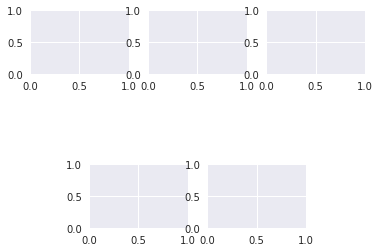

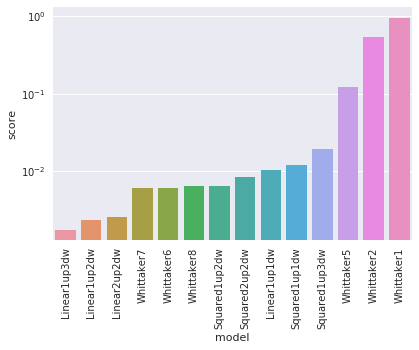

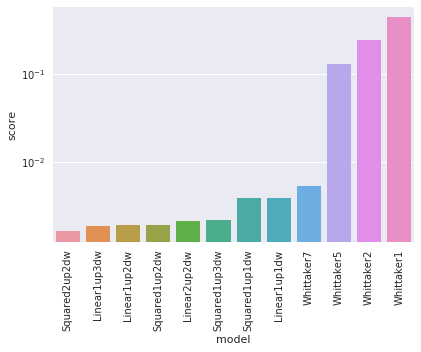

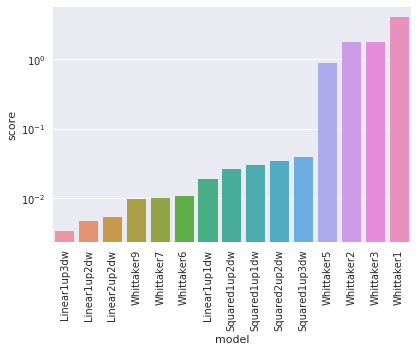

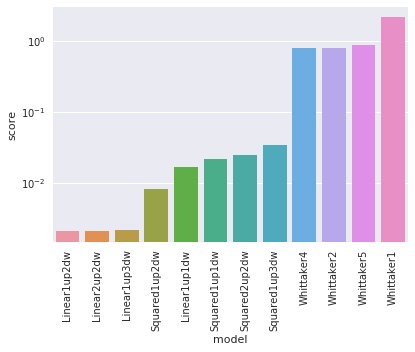

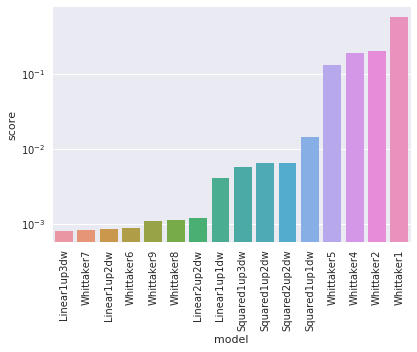

In [43]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(3, 6)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:4])
ax3 = plt.subplot(gs[0, 4:])
ax4 = plt.subplot(gs[2, 1:3])
ax5 = plt.subplot(gs[2, 3:5])
for rut, ax in zip(filtered_hists,[ax1,ax2,ax3,ax4,ax5]):
    g = sns.factorplot(
        x='model', 
        y='score', 
#         col='repeat_unit_type', 
#         data=sdf, 
        data=sdf[sdf['repeat_unit_type']==rut],
        kind='bar', 
        order=sdf[sdf['repeat_unit_type']==rut].sort('score')['model'],
#         col_order=['AC', 'AG', 'AT', 'A', 'G'],
        size=4, 
        aspect=1.5,
    )
    g.set_xticklabels(rotation=90)
    g.fig.get_axes()[0].set_yscale('log')
#     plt.savefig('/home/ofirr/s/Ofir/{}_model_comparison.pdf'.format(rut), bbox_inches='tight')
plt.show()

In [21]:
model_labels = ['Linear1up3dw',
'Linear1up2dw',
'Linear2up2dw',
'Whittaker9',
'Whittaker8',
'Whittaker7',
'Whittaker6',
'Linear1up1dw',
'Squared1up2dw',
'Squared1up1dw',
'Squared2up2dw',
'Squared1up3dw',
'Whittaker5',
'Whittaker4',
'Whittaker2',
'Whittaker3',
'Whittaker1',
]

In [24]:
palette = dict(zip(model_labels, sns.color_palette("husl", len(model_labels))))
palette
# palette ={"A":"C0","B":"C1","C":"C2", "Total":"k"}

{'Linear1up1dw': (0.20260140137245986, 0.6888777365691905, 0.5073931192355193),
 'Linear1up2dw': (0.9709475908389634,
  0.46403989737619705,
  0.23268163300341138),
 'Linear1up3dw': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 'Linear2up2dw': (0.8233753136307219, 0.5564097629441267, 0.19515040910202758),
 'Squared1up1dw': (0.21283940026780146,
  0.6736342952276683,
  0.6790583455137678),
 'Squared1up2dw': (0.20806612541243952,
  0.6808998626985141,
  0.6056504754121731),
 'Squared1up3dw': (0.2276041189151808, 0.6492591618617503, 0.8667352328785314),
 'Squared2up2dw': (0.21840821737392985,
  0.6647898200401803,
  0.7553445340026518),
 'Whittaker1': (0.964715581208501, 0.4175934015417711, 0.6999430436310112),
 'Whittaker2': (0.8753266398274079, 0.4280264074507189, 0.9577762021967094),
 'Whittaker3': (0.9609894338512172, 0.3866875852472021, 0.8475770545475213),
 'Whittaker4': (0.690592305012026, 0.5310029892694575, 0.9581797268573365),
 'Whittaker5': (0.4646464939986733

/home/ofirr/.venvs/cl/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  # Remove the CWD from sys.path while we load stuff.

/home/ofirr/.venvs/cl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



A


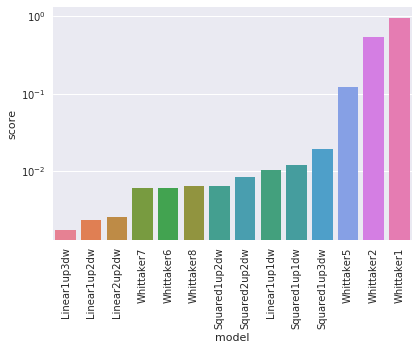

AC


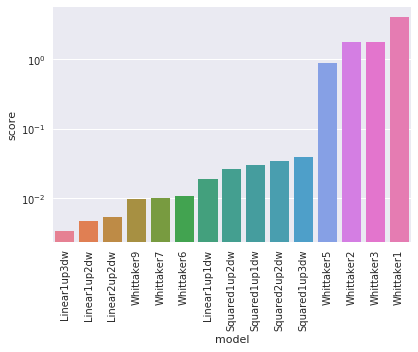

AG


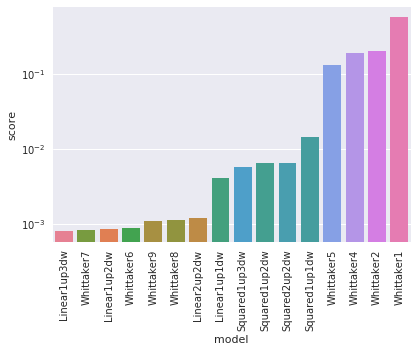

G


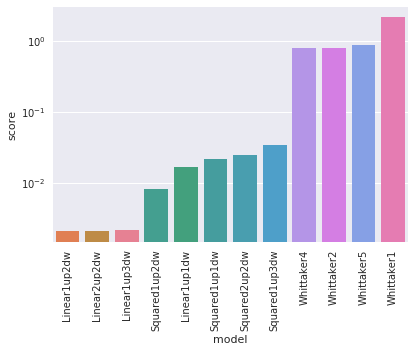

AT


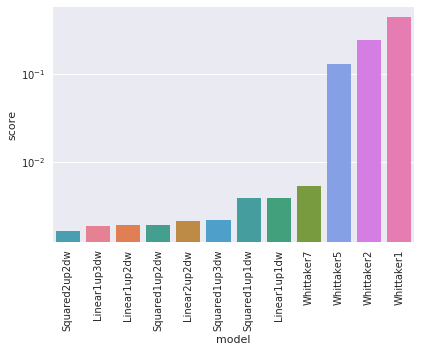

In [30]:
for rut in filtered_hists:
    print(rut)
    g = sns.factorplot(
        x='model', 
        y='score', 
#         col='repeat_unit_type', 
#         data=sdf, 
        data=sdf[sdf['repeat_unit_type']==rut],
        kind='bar', 
        order=sdf[sdf['repeat_unit_type']==rut].sort('score')['model'],
#         col_order=['AC', 'AG', 'AT', 'A', 'G'],
        size=4, 
        aspect=1.5,
        palette=palette,
    )
    g.set_xticklabels(rotation=90)
    g.fig.get_axes()[0].set_yscale('log')
    plt.savefig('/home/ofirr/s/Ofir/{}_model_comparison.pdf'.format(rut), bbox_inches='tight')
    plt.show()

/home/ofirr/.venvs/cl/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  # Remove the CWD from sys.path while we load stuff.



AC


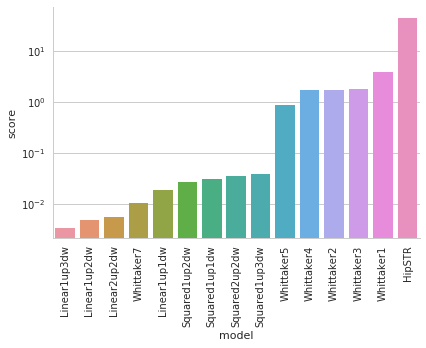

AG


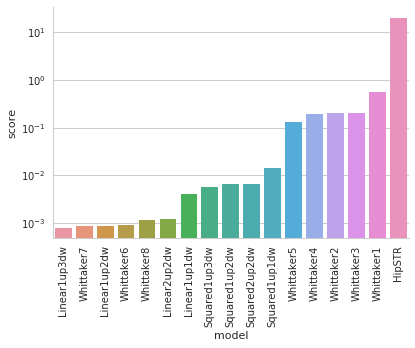

AT


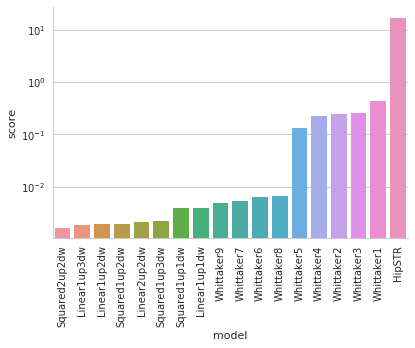

A


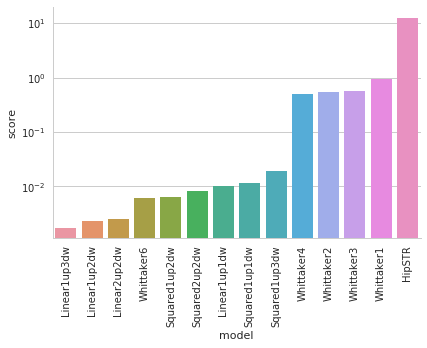

G


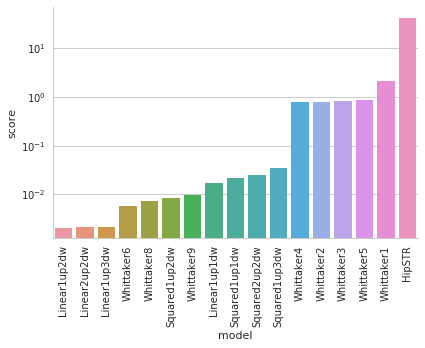

In [79]:
for rut in ['AC', 'AG', 'AT', 'A', 'G']:
    print(rut)
    g = sns.factorplot(
        x='model', 
        y='score', 
#         col='repeat_unit_type', 
#         data=sdf, 
        data=sdf[sdf['repeat_unit_type']==rut],
        kind='bar', 
        order=sdf[sdf['repeat_unit_type']==rut].sort('score')['model'],
#         col_order=['AC', 'AG', 'AT', 'A', 'G'],
        size=4, 
        aspect=1.5,
    )
    g.set_xticklabels(rotation=90)
    g.fig.get_axes()[0].set_yscale('log')
    plt.savefig('/home/ofirr/s/Ofir/{}_model_comparison.pdf'.format(rut), bbox_inches='tight')
    plt.show()